In [7]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display

import SimpleITK as sitk

In [5]:
def memory_function(infile, dataset):
    with open(infile, 'r') as mem:
        lines = mem.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar), linewidth=5)
    ax.set_ylabel(r'mem use (GB)', fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)
    ax.set_title(r'%s max = %.2f GB; mean = %.2f GB' % (dataset, max(testar) - np.min(testar), np.mean(testar) - np.min(testar)), fontsize=20)
    fig.set_size_inches(8, 2)
    fig.tight_layout()
    return fig

def cpu_function(infile, dataset):
    with open(infile, 'r') as cpuf:
        lines = cpuf.readlines()

    testar = [re.split(',',line.strip()) for line in lines][0:-1]
    
    corear = np.zeros((len(testar), len(testar[0])))
    for i in range(0, len(testar)):
        corear[i,:] = np.array([float(cpu) for cpu in testar[i]])
    
    fig=plt.figure()
    ax = fig.add_subplot(111)
    lines = [ax.plot(corear[:,i], '--', label='cpu '+ str(i), 
                     alpha=0.5, linewidth=5)[0] for i in range(0, corear.shape[1])]
    
    total = corear.sum(axis=1)
    lines.append(ax.plot(total, label='all cores')[0])
    
    labels = [h.get_label() for h in lines]
    
    fig.legend(handles=lines, labels=labels, loc='lower center', prop={'size':20},ncol=2, bbox_to_anchor=(0.5, -.14))
    ax.set_ylabel('CPU use (%)', fontsize=20)
    ax.set_ylim([0, max(total)+10])
    ax.set_xlabel('Time (s)', fontsize=20)
    ax.set_title('%s max = %.1f; mean = %.1f' % (dataset, max(total), np.mean(total)), fontsize=20)
    fig.set_size_inches(8, 2)
    fig.tight_layout()
    return fig

def disk_function(infile, dataset):
    with open(infile, 'r') as disk:
        lines = disk.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('Disk usage GB')
    ax.set_xlabel('Time (30 s)')
    ax.set_title('%s max = %.2f GB; mean = %.2f GB' % (dataset, max(testar) - np.min(testar), np.mean(testar) - np.min(testar)))
    return fig

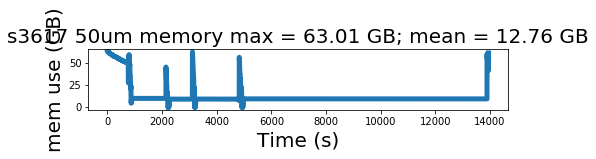

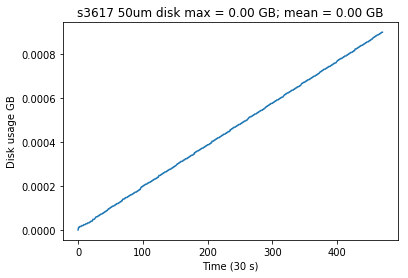

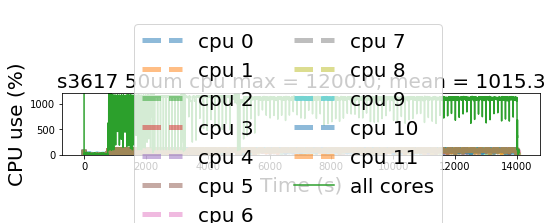

In [6]:
memfig = memory_function('profiling_output/mem.txt', 's3617 50um memory')
diskfig = disk_function('profiling_output/disk.txt', 's3617 50um disk')
cpufig = cpu_function('profiling_output/cpu.txt', 's3617 50um cpu')
# display(Image(filename='/data/BIDs_test/sub-0025864/outputs/qa/sub-0025864_ses-1_bold/reg/func/align/template/fnirt_score_851/sub-0025864_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()

In [ ]:
image_2 = sitk.ReadImage('s3617_cutout.tif')